# Homework 3

## Course Name: Deep Learning
#### Lecturer: Dr. Beigy

---

#### Notebooks Supervised By: Zeinab Sadat Taghavi
#### Notebooks Prepared By: Zahra Rahimi, Zahra Khoramnejad, Mehran Sarmadi

**Contact**: Ask your questions in Quera

---

**Note**: Replace the placeholders (between `## COMPLETE THE FOLLOWING SECTION  ##` and `## THE END ##`) with the appropriate details.


---
---
## 1 Introduction

In this notebook you have to design and train models for a time series prediction task on the provided dataset using these three different architectures:

- Simple RNN

- GRU

- LSTM

You will compare and rank them at the end of the notebook and explain why they were ranked that way.

---
### 1.1 Imports

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data
import copy

---
---
## 2 Dataset
Electric Production IP Dataset

In [3]:
df = pd.read_csv('Electric_Production.csv', index_col='Date', parse_dates=True, dtype=np.float32)

In [4]:
df.head()

,Value
Date,
1985-01-01,72.505203
1985-02-01,70.671997
1985-03-01,62.450199
1985-04-01,57.471401
1985-05-01,55.315102


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float32
dtypes: float32(1)
memory usage: 4.7 KB


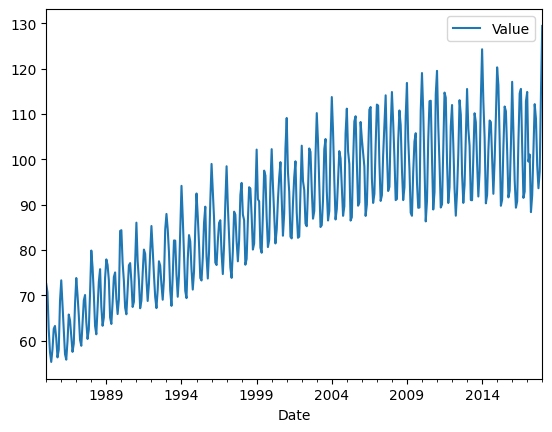

In [6]:
df.plot();

---
### 2.1 Load and prepare Dataset

In [7]:
def prepare_dataset(dataset, look_back):
    """Transform a time series data into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        look_back: Size of window for prediction
    """
    X, y = [], []
    dataset = np.array(dataset)
    data_length = len(dataset)
    for i in range(look_back, data_length):
        input = dataset[i-look_back: i]
        output = dataset[i]
        X.append(input)
        y.append(output)

    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [66]:
look_back = 15

data_length = len(df)

train_data_size = int(data_length * 0.75)
validaion_data_size = int(data_length * 0.25)


train_data = df[: train_data_size]
validation_data = df[train_data_size: ]


X_train, y_train = prepare_dataset(train_data, look_back)
X_val, y_val = prepare_dataset(validation_data, look_back)


X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)


print(  f"Shape of X_train data -> {X_train.shape} \n"
        f"Shape of y_train data -> {y_train.shape} \n"
        f"Shape of X_val data -> {X_val.shape} \n"
        f"Shape of y_val data -> {y_val.shape} \n"
    )


Shape of X_train data -> torch.Size([282, 15, 1]) 
Shape of y_train data -> torch.Size([282, 1]) 
Shape of X_val data -> torch.Size([85, 15, 1]) 
Shape of y_val data -> torch.Size([85, 1]) 



---
---
## 3 Trainer function

In [67]:
def trainer(model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs):
    early_stopping_patience = 150
    early_stopping_counter = 0

    valid_loss_min=np.inf
    best_model = copy.deepcopy(model)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        # - You can feed all the data to the model at once because the data is small.
        #################################################################################

        # Forward and loss
        optimizer.zero_grad()
        output = model(X_train)
        train_loss = criterion(output, y_train)
        train_losses.append(train_loss.item())

        # Backward and optimization
        train_loss.backward()
        optimizer.step()

        #################################################################################
        #                                   THE END                                     #
        #################################################################################


        with torch.no_grad():
            model.eval()
            output_val = model(X_val)
            valid_loss = criterion(output_val, y_val)
            val_losses.append(valid_loss.item())

            if valid_loss <= valid_loss_min:
                best_model = copy.deepcopy(model)
                print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).')
                valid_loss_min = valid_loss
                early_stopping_counter = 0    # Reset counter if validation loss decreases
            else:
                print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
                early_stopping_counter += 1

            if early_stopping_counter > early_stopping_patience:
                print('Early stopped at epoch :', epoch)
                break

            print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

    return best_model, train_losses, val_losses

---
---
## 4 RNN

---
### 4.1 Define single RNN cell

In [68]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(RNNCell, self).__init__()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Needed Layers """
				#Your Code Here
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

#################################################################################
#                                   THE END                                     #
#################################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def forward(self, input, hx=None):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Forward pass"""
				#Your Code Here
        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        hy = (self.x2h(input) + self.h2h(hx))

        if self.nonlinearity == "tanh":
            hy = torch.tanh(hy)
        else:
            hy = torch.relu(hy)
#################################################################################
#                                   THE END                                     #
#################################################################################
        return hy

---
### 4.2 RNN model

In [69]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(SimpleRNN, self).__init__()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Needed Layers"""
				#Your Code Here
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()


        self.rnn_cell_list.append(RNNCell(self.input_size,
                                                self.hidden_size,
                                                self.bias,
                                                "tanh"))
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(RNNCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias,
                                                    "tanh"))

        self.fc = nn.Linear(self.hidden_size, self.output_size)

#################################################################################
#                                   THE END                                     #
#################################################################################


    def forward(self, input, hx=None):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Forward pass"""
				#Your Code Here
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])

        for t in range(input.size(1)):
            for layer in range(self.num_layers):
                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer-1], hidden[layer])

                hidden[layer] = hidden_l

            outs.append(hidden_l)

        # Take only last time step. Modify for seq to seq
        out = outs[-1].squeeze()
        out = self.fc(out)
#################################################################################
#                                   THE END                                     #
#################################################################################
        return out

---
### 4.3 Train RNN model and plot losses

In [70]:
# Instantiate model
SimpleRNN_model = SimpleRNN(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
SimpleRNN_model.to(device)

SimpleRNN(
  (rnn_cell_list): ModuleList(
    (0): RNNCell(
      (x2h): Linear(in_features=1, out_features=50, bias=True)
      (h2h): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [71]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SimpleRNN_model.parameters(), lr = learning_rate)

In [72]:
SimpleRNN_best_model, train_losses, val_losses = trainer(SimpleRNN_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Epoch 0: Validation loss decreased (inf --> 10401.469727).
	 Train_Loss: 7407.9033 Val_Loss: 10401.4697  BEST VAL Loss: 10401.4697

Epoch 1: Validation loss decreased (10401.469727 --> 10290.982422).
	 Train_Loss: 7287.7676 Val_Loss: 10290.9824  BEST VAL Loss: 10290.9824

Epoch 2: Validation loss decreased (10290.982422 --> 10183.958984).
	 Train_Loss: 7193.4473 Val_Loss: 10183.9590  BEST VAL Loss: 10183.9590

Epoch 3: Validation loss decreased (10183.958984 --> 10091.898438).
	 Train_Loss: 7106.1665 Val_Loss: 10091.8984  BEST VAL Loss: 10091.8984

Epoch 4: Validation loss decreased (10091.898438 --> 10003.226562).
	 Train_Loss: 7029.1621 Val_Loss: 10003.2266  BEST VAL Loss: 10003.2266

Epoch 5: Validation loss decreased (10003.226562 --> 9909.139648).
	 Train_Loss: 6953.2642 Val_Loss: 9909.1396  BEST VAL Loss: 9909.1396

Epoch 6: Validation loss decreased (9909.139648 --> 9810.726562).
	 Train_Loss: 6873.1646 Val_Loss: 9810.7266  BEST VAL Loss: 9810.7266

Epoch 7: Validation loss decr

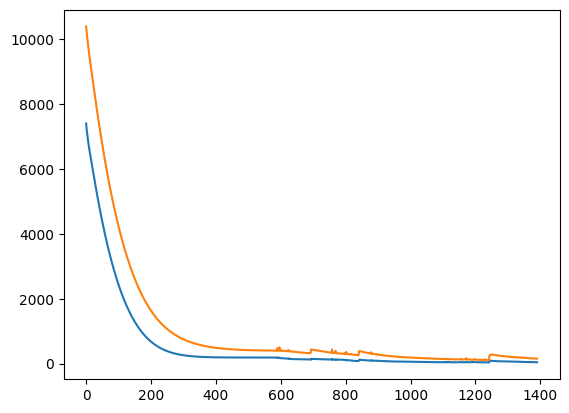

In [73]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 4.4 Evaluate model on validation data

In [74]:
val_predict_RNN = SimpleRNN_best_model(X_val)

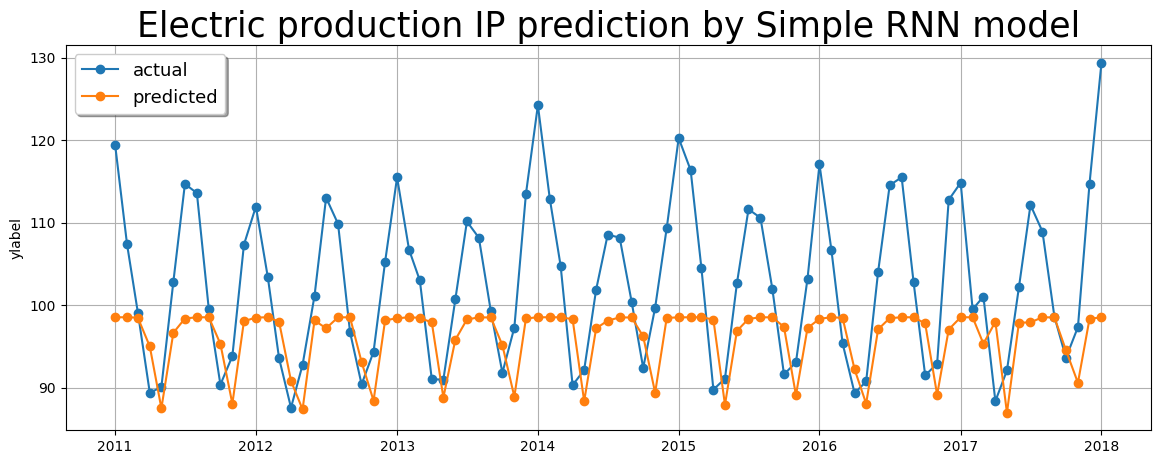

In [75]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_RNN.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by Simple RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 5 GRU

---
### 5.1 Define single GRU cell

In [76]:
class GRUCell(torch.nn.Module):
    """
    A simple GRU cell network for educational purposes
    """

    def __init__(self, input_length=10, hidden_size=20, bias=True):
        super(GRUCell, self).__init__()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Needed Layers """
		#Your Code Here
        self.input_length = input_length
        self.hidden_size = hidden_size
        self.bias = bias

        # reset gate
        self.x2hr = nn.Linear(input_length, hidden_size, bias=bias)
        self.h2hr = nn.Linear(hidden_size, hidden_size, bias=bias)

        # update gate
        self.x2hu = nn.Linear(input_length, hidden_size, bias=bias)
        self.h2hu = nn.Linear(hidden_size, hidden_size, bias=bias)

        # output gate
        self.x2ho = nn.Linear(input_length, hidden_size, bias=bias)
        self.h2ho = nn.Linear(hidden_size, hidden_size, bias=bias)

#################################################################################
#                                   THE END                                     #
#################################################################################
        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def reset_gate(self, x, h):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
	    #Your Code Here
        x_reset = self.x2hr(x)
        h_reset = self.h2hr(h)

        r = torch.sigmoid(x_reset + h_reset)
#################################################################################
#                                   THE END                                     #
#################################################################################
        return r


    def update_gate(self, x, h):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
		#Your Code Here
        x_update = self.x2hu(x)
        h_update = self.h2hu(h)

        z = torch.sigmoid(x_update + h_update)
#################################################################################
#                                   THE END                                     #
#################################################################################
        return z


    def output_gate(self, x, h, r):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
		#Your Code Here
        x_output = self.x2ho(x)
        h_output = self.h2ho(h)

        n_t = torch.tanh(x_output + (r * h_output))
#################################################################################
#                                   THE END                                     #
#################################################################################
        return n_t


    def forward(self, x, h):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Forward pass"""
		#Your Code Here
        reset_gate = self.reset_gate(x, h)
        update_gate = self.update_gate(x, h)
        new_gate = self.output_gate(x, h, reset_gate)

        h_new = update_gate * h + (1 - update_gate) * new_gate

#################################################################################
#                                   THE END                                     #
#################################################################################
        return h_new

---
### 5.2 GRU model

In [77]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(GRU, self).__init__()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Needed Layers"""
        #Your Code Here
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()

        self.rnn_cell_list.append(GRUCell(self.input_size,
                                          self.hidden_size,
                                          self.bias))
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                              self.hidden_size,
                                              self.bias))
        self.fc = nn.Linear(self.hidden_size, self.output_size)

#################################################################################
#                                   THE END                                     #
#################################################################################


    def forward(self, input, hx=None):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Forward pass"""
        #Your Code Here
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])

        for t in range(input.size(1)):

            for layer in range(self.num_layers):

                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer - 1],hidden[layer])
                hidden[layer] = hidden_l

                hidden[layer] = hidden_l

            outs.append(hidden_l)

        # Take only last time step. Modify for seq to seq
        out = outs[-1].squeeze()

        out = self.fc(out)

        return out

#################################################################################
#                                   THE END                                     #
#################################################################################
        return out

---
### 5.3 Train GRU model and plot losses

In [78]:
GRU_model = GRU(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
GRU_model.to(device)

GRU(
  (rnn_cell_list): ModuleList(
    (0): GRUCell(
      (x2hr): Linear(in_features=1, out_features=50, bias=True)
      (h2hr): Linear(in_features=50, out_features=50, bias=True)
      (x2hu): Linear(in_features=1, out_features=50, bias=True)
      (h2hu): Linear(in_features=50, out_features=50, bias=True)
      (x2ho): Linear(in_features=1, out_features=50, bias=True)
      (h2ho): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [79]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(GRU_model.parameters(), lr = learning_rate)

In [80]:
GRU_best_model, train_losses, val_losses = trainer(GRU_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Streaming output truncated to the last 5000 lines.
	 Train_Loss: 234.8264 Val_Loss: 684.0196  BEST VAL Loss: 684.0196

Epoch 334: Validation loss decreased (684.019592 --> 680.366028).
	 Train_Loss: 233.7478 Val_Loss: 680.3660  BEST VAL Loss: 680.3660

Epoch 335: Validation loss decreased (680.366028 --> 676.754517).
	 Train_Loss: 232.6899 Val_Loss: 676.7545  BEST VAL Loss: 676.7545

Epoch 336: Validation loss decreased (676.754517 --> 673.187317).
	 Train_Loss: 231.6522 Val_Loss: 673.1873  BEST VAL Loss: 673.1873

Epoch 337: Validation loss decreased (673.187317 --> 669.662354).
	 Train_Loss: 230.6352 Val_Loss: 669.6624  BEST VAL Loss: 669.6624

Epoch 338: Validation loss decreased (669.662354 --> 666.178345).
	 Train_Loss: 229.6376 Val_Loss: 666.1783  BEST VAL Loss: 666.1783

Epoch 339: Validation loss decreased (666.178345 --> 662.737061).
	 Train_Loss: 228.6596 Val_Loss: 662.7371  BEST VAL Loss: 662.7371

Epoch 340: Validation loss decreased (662.737061 --> 659.336243).
	 Train_Los

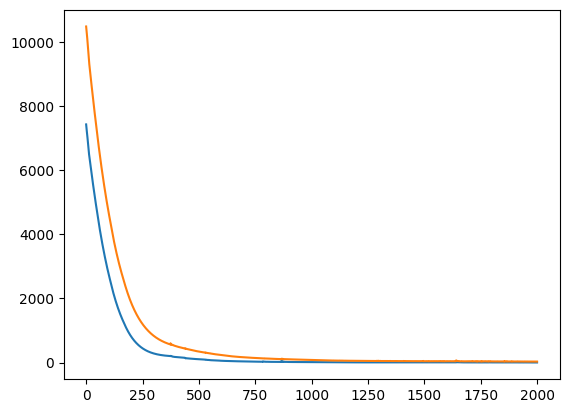

In [81]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 5.4 Evaluate model on validation data

In [82]:
val_predict_GRU = GRU_best_model(X_val)

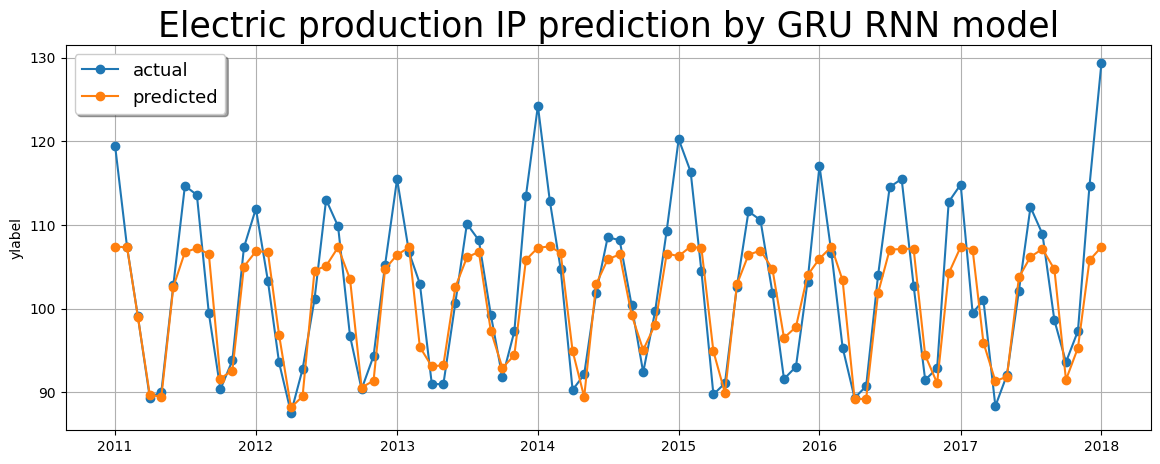

In [83]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_GRU.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by GRU RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 6 LSTM

---
### 6.1 Define single RNN cell

In [84]:
class LSTMCell(torch.nn.Module):
    """
    A simple LSTM cell network for educational AI-summer purposes
    """
    def __init__(self, input_length=10, hidden_size=20, bias=True):
        super(LSTMCell, self).__init__()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Needed Layers """
        #Your Code Here
        self.input_length = input_length
        self.hidden_size = hidden_size
        self.bias = bias

        # input gate
        self.x2hi = nn.Linear(input_length, hidden_size, bias=bias)
        self.h2hi = nn.Linear(hidden_size, hidden_size, bias=bias)

        # forget gate
        self.x2hf = nn.Linear(input_length, hidden_size, bias=bias)
        self.h2hf = nn.Linear(hidden_size, hidden_size, bias=bias)

        # cell state manipulation gate
        self.x2hg = nn.Linear(input_length, hidden_size, bias=bias)
        self.h2hg = nn.Linear(hidden_size, hidden_size, bias=bias)

        # output gate
        self.x2ho = nn.Linear(input_length, hidden_size, bias=bias)
        self.h2ho = nn.Linear(hidden_size, hidden_size, bias=bias)

#################################################################################
#                                   THE END                                     #
#################################################################################
        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def forget_gate(self, x, h):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        #Your Code Here
        x_forget = self.x2hf(x)
        h_forget = self.h2hf(h)

        fg = torch.sigmoid(x_forget + h_forget)

#################################################################################
#                                   THE END                                     #
#################################################################################
        return fg


    def input_gate(self, x, h):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        #Your Code Here
        x_input = self.x2hi(x)
        h_input = self.h2hi(h)

        ig = torch.sigmoid(x_input + h_input)

#################################################################################
#                                   THE END                                     #
#################################################################################
        return ig


    def cell_memory_gate(self, i, f, x, h, c_prev):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        #Your Code Here
        x_cell = self.x2hg(x)
        h_cell = self.h2hg(h)

        gg = torch.tanh(x_cell + h_cell)

        c_next = c_prev * f + i * gg

#################################################################################
#                                   THE END                                     #
#################################################################################
        return c_next


    def output_gate(self, x, h):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        #Your Code Here
        x_output = self.x2ho(x)
        h_output = self.h2ho(h)

        og = torch.sigmoid(x_output + h_output)

#################################################################################
#                                   THE END                                     #
#################################################################################
        return og


    def forward(self, x, hx=None):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Forward pass"""
        #Your Code Here
        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        hx, cx = hx

        i = self.input_gate(x, hx)
        f = self.forget_gate(x, hx)
        c_next = self.cell_memory_gate(i, f, x, hx, cx)
        o = self.output_gate(x, hx)

        h_next = o * torch.tanh(c_next)

#################################################################################
#                                   THE END                                     #
#################################################################################
        return h_next, c_next

---
### 6.2 LSTM model

In [85]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(LSTM, self).__init__()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Needed Layers"""
        #Your Code Here
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()

        self.rnn_cell_list.append(LSTMCell(self.input_size,
                                            self.hidden_size,
                                            self.bias))
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                self.hidden_size,
                                                self.bias))

        self.fc = nn.Linear(self.hidden_size, self.output_size)

#################################################################################
#                                   THE END                                     #
#################################################################################


    def forward(self, input, hx=None):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        """Define Forward pass"""
        #Your Code Here
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
        else:
             h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append((h0[layer, :, :], h0[layer, :, :]))

        for t in range(input.size(1)):
            for layer in range(self.num_layers):
                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](
                        input[:, t, :],
                        (hidden[layer][0],hidden[layer][1])
                        )
                else:
                    hidden_l = self.rnn_cell_list[layer](
                        hidden[layer - 1][0],
                        (hidden[layer][0], hidden[layer][1])
                        )

                hidden[layer] = hidden_l

            outs.append(hidden_l[0])

        out = outs[-1].squeeze()
        out = self.fc(out)

#################################################################################
#                                   THE END                                     #
#################################################################################
        return out

---
### 6.3 Train LSTM model and plot losses

In [86]:
LSTM_model = LSTM(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
LSTM_model.to(device)

LSTM(
  (rnn_cell_list): ModuleList(
    (0): LSTMCell(
      (x2hi): Linear(in_features=1, out_features=50, bias=True)
      (h2hi): Linear(in_features=50, out_features=50, bias=True)
      (x2hf): Linear(in_features=1, out_features=50, bias=True)
      (h2hf): Linear(in_features=50, out_features=50, bias=True)
      (x2hg): Linear(in_features=1, out_features=50, bias=True)
      (h2hg): Linear(in_features=50, out_features=50, bias=True)
      (x2ho): Linear(in_features=1, out_features=50, bias=True)
      (h2ho): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [87]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr = learning_rate)

In [88]:
LSTM_best_model, train_losses, val_losses = trainer(LSTM_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Epoch 0: Validation loss decreased (inf --> 10500.412109).
	 Train_Loss: 7419.9458 Val_Loss: 10500.4121  BEST VAL Loss: 10500.4121

Epoch 1: Validation loss decreased (10500.412109 --> 10437.936523).
	 Train_Loss: 7369.4644 Val_Loss: 10437.9365  BEST VAL Loss: 10437.9365

Epoch 2: Validation loss decreased (10437.936523 --> 10369.936523).
	 Train_Loss: 7314.8481 Val_Loss: 10369.9365  BEST VAL Loss: 10369.9365

Epoch 3: Validation loss decreased (10369.936523 --> 10310.365234).
	 Train_Loss: 7258.8926 Val_Loss: 10310.3652  BEST VAL Loss: 10310.3652

Epoch 4: Validation loss decreased (10310.365234 --> 10266.351562).
	 Train_Loss: 7212.2065 Val_Loss: 10266.3516  BEST VAL Loss: 10266.3516

Epoch 5: Validation loss decreased (10266.351562 --> 10228.101562).
	 Train_Loss: 7175.3491 Val_Loss: 10228.1016  BEST VAL Loss: 10228.1016

Epoch 6: Validation loss decreased (10228.101562 --> 10188.106445).
	 Train_Loss: 7140.9453 Val_Loss: 10188.1064  BEST VAL Loss: 10188.1064

Epoch 7: Validation lo

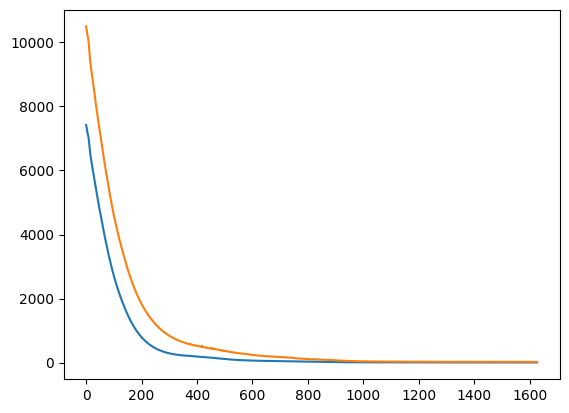

In [89]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 6.4 Evaluate model on validation data

In [90]:
val_predict_LSTM = LSTM_best_model(X_val)

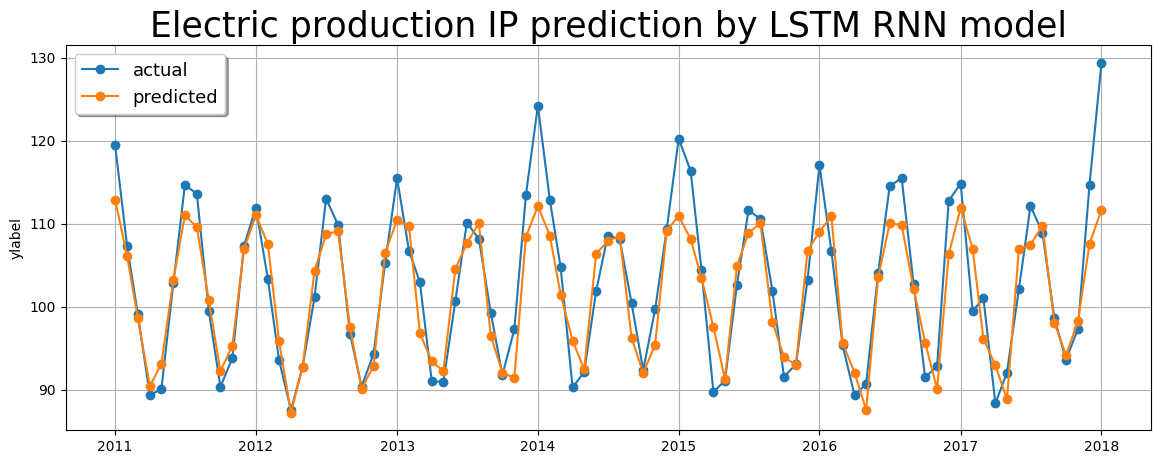

In [91]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_LSTM.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by LSTM RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 7 Comaprison

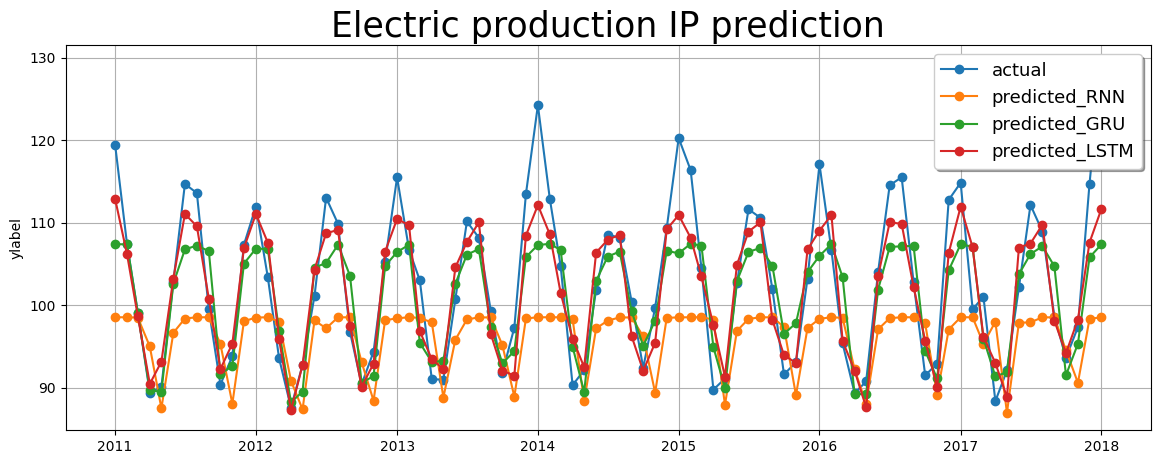

In [92]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_RNN.detach().cpu(), label="predicted_RNN", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_GRU.detach().cpu(), label="predicted_GRU", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_LSTM.detach().cpu(), label="predicted_LSTM", marker="o")
plt.title("Electric production IP prediction", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()


<b>1-Rank these architectures based on their performance?

2-Why are they ranked in this order?

3-Run the notebook again with look_back = 15.
write about the difference in the comparison plot and the possible cause for that difference.</b>

<font color='#73FF73'><b>Your answer:</b></font> \
Answer 1) \
LSTM > GRU > RNN

Answer 2) \
Cause LSTM could estimate the temporal pattern better than other two models. however there are some noises in the estimation but overall temporal pattern has been preserved in the LSTM prediction. Also GRU has acceptable predictions but there are some errors in the prediction. RNN, could understand overall temporal pattern but the result shows that it's too naive to estimate the details of the pattern.

Answer 3) \
loop_back = 60
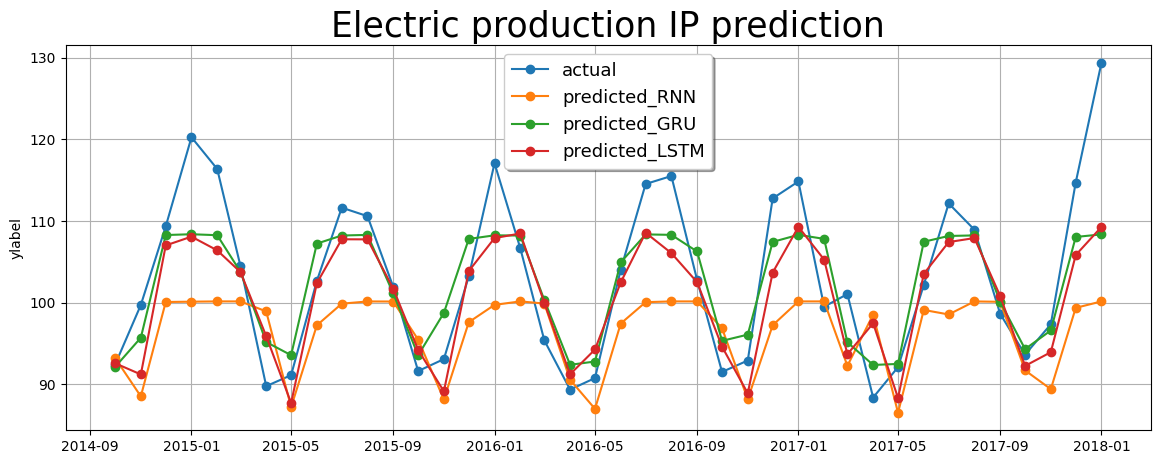
loop_back = 15
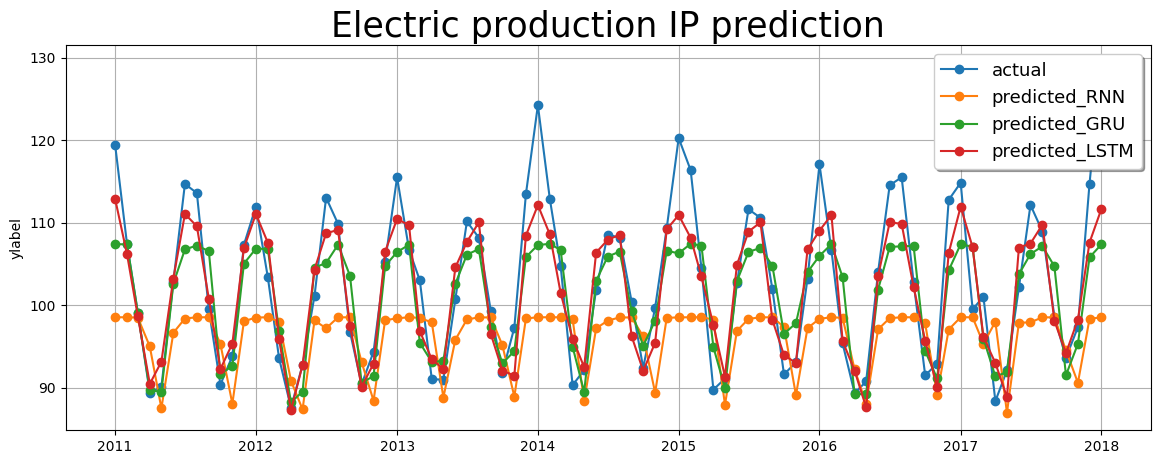

One reason I can mention is about locality of the input samples. when you have a small window view of past samples, you have more attention to the local changes, however when this window gets bigger, the locality tends to decrease. perhaps, that's one of the causes of the effect of loop_back size on the models predictions.